В данном домашнем задании вам необходимо:

1. Используйте датасет "Собаки и кошки", рассмотренный в данном уроке. Причем используйте его целиком, а не только 4000 изображений.
2. Проведите аугментацию изображений.
3. В качестве предобученной модели возьмите `MobileNet`
4. Создайте модель, приведенную ниже.
5. Обучите модель и проверьте на тестовой выборке.
6. Если модель не обеспечивает заданную точность - "поиграйтесь" с гиперпараметрами.


Для получения 3 баллов за задание необходимо достичь на контрольной выборке точности 90%, 4 баллов -  более 93%, 5 баллов - более 95%.

На 20 тыс. изображений данная модель выдавала нам результат 99%.

**Подсказка**. Обратите внимание, что предлагаемая модель уже не является бинарной классификацией. Это уже задача многоклассовой классификации (в нашем случае 2 класса). А значит в генераторах изображений необходимо использовать:

```pyton
class_mode='categorical'
```

Также необходимо вспомнить какую функцию ошибки использовать с задачей многоклассовой классификации. Можно попробовать в качестве оптимизатора использовать Adam с разными шагами.

Также обратите внимание, что вместо слоя `Flatten()`, вам предлагается использовать `GlobalAveragePooling2D()` (https://keras.io/api/layers/pooling_layers/global_average_pooling2d/).


In [ ]:
import os
import shutil
from keras import layers, Input, Model
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -qo "kagglecatsanddogs_5340" -d ./temp

In [ ]:
IMAGE_PATH = './temp/PetImages/'
BASE_DIR = './dataset/'

CLASS_LIST = sorted(os.listdir(IMAGE_PATH))
NUM_CLASSES = len(CLASS_LIST)

IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)

In [ ]:
def create_dataset(img_path: str, new_path: str, class_name: str, start_index: int, end_index: int):
    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса

    # удалить файлы, не подходящие для обучения
    not_img = os.path.join(src_path, 'Thumbs.db')
    if os.path.isfile(not_img):
        os.remove(not_img)
    not_img = os.path.join(src_path, '666.jpg')
    if os.path.isfile(not_img):
        os.remove(not_img)
    not_img = os.path.join(src_path, '11702.jpg')
    if os.path.isfile(not_img):
        os.remove(not_img)

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(src_path)
    # Создаем подпапку, используя путь
    if not os.path.exists(dst_path):
        os.mkdir(dst_path)

    for fname in class_files[start_index: end_index]:
        src = os.path.join(src_path, fname)
        dst = os.path.join(dst_path, fname)
        shutil.copyfile(src, dst)


for class_label in range(NUM_CLASSES):
    class_name = CLASS_LIST[class_label]
    create_dataset(IMAGE_PATH, train_dir, class_name, 0, 9100)
    create_dataset(IMAGE_PATH, validation_dir, class_name, 9100, 11000)
    create_dataset(IMAGE_PATH, test_dir, class_name, 11000, 12500)

In [ ]:
def get_dir(name_dir):
    for subdir in os.walk(name_dir):
        if subdir[2]:
            yield subdir[0].split("/")[-1], len(subdir[2])


print('Тренировочный набор:\n', [i for i in get_dir(train_dir)])
print('Валидационный набор:\n', [i for i in get_dir(validation_dir)])
print('Тестовый набор:\n', [i for i in get_dir(test_dir)])

Тренировочный набор:
 [('Cat', 9100), ('Dog', 9100)]
Валидационный набор:
 [('Cat', 1900), ('Dog', 1900)]
Тестовый набор:
 [('Cat', 1498), ('Dog', 1498)]


In [ ]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)

In [ ]:
model = model_maker()
model.summary()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=20,
                                                    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                        batch_size=20, class_mode='categorical')

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['acc'])
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Found 18200 images belonging to 2 classes.
Found 3800 images belonging to 2 classes.
Epoch 1/10
910/910 [==============================] - 246s 264ms/step - loss: 0.2066 - acc: 0.9134 - val_loss: 0.0533 - val_acc: 0.9797
Epoch 2/10
910/910 [==============================] - 238s 262ms/step - loss: 0.1065 - acc: 0.9585 - val_loss: 0.0442 - val_acc: 0.9839
Epoch 3/10
910/910 [==============================] - 238s 262ms/step - loss: 0.0934 - acc: 0.9637 - val_loss: 0.0398 - val_acc: 0.9845
Epoch 4/10
910/910 [==============================] - 247s 271ms/step - loss: 0.0838 - acc: 0.9674 - val_loss: 0.0363 - val_acc: 0.9861
Epoch 5/10
910/910 [==============================] - 255s 280ms/step - loss: 0.0772 - acc: 0.9714 - val_loss: 0.0351 - val_acc: 0.9855
Epoch 6/10
910/910 [==============================] - 239s 263ms/step - loss: 0.0727 - acc: 0.9718 - val_loss: 0.0359 - val_acc: 0.9866
Epoch 7/10
910/910 [==============================] - 240s 264ms/step - loss: 0.0729 - acc: 0.9711 

In [ ]:
def show_history(store):
    acc = store.history['acc']
    val_acc = store.history['val_acc']
    loss = store.history['loss']
    val_loss = store.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')
    plt.title('График точности на проверочной и обучающей выборках')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'bo', label='Потери на проверочной выборке')
    plt.title('График потерь на проверочной и обучающей выборках')
    plt.legend()
    plt.show()

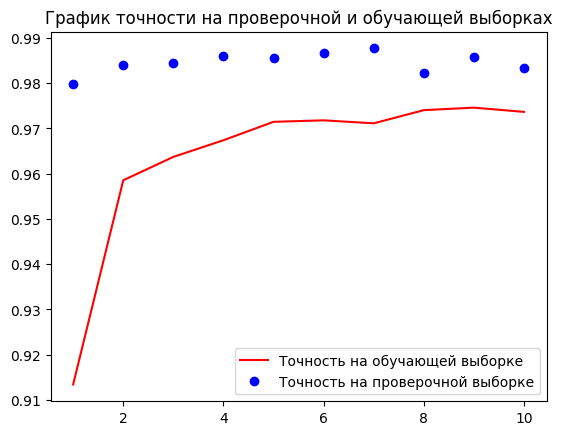

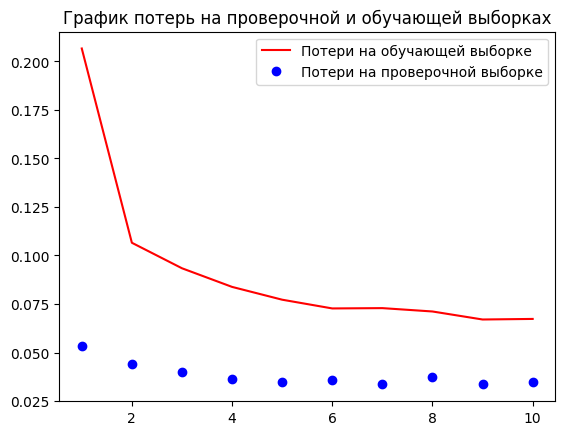

In [ ]:
show_history(history)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=20,
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print('Точность на контрольной выборке:', test_acc)

Found 2996 images belonging to 2 classes.
150/150 [==============================] - 12s 81ms/step - loss: 0.0340 - acc: 0.9860
Точность на контрольной выборке: 0.985981285572052
